In [1]:
import sys
sys.path.insert(1, '../')
sys.path.insert(1, '../../')
import numpy as np
import matplotlib.pyplot as plt
from util.fft import * 
from util.phantom import * 
from util.coil import * 
from util.tool import * 

In [2]:
import scipy.io
def get_tissue_images(slices):
    tissuetype = ['graymatter', 'deep_graymatter', 'whitematter', 'csf']
    T2 = [110, 100, 60, 1500]
    T2s = [40, 45, 50, 1000]
    mat = scipy.io.loadmat('../lib/resource/data/tissue_images/tissue_images.mat')
    tissues = mat.get("tissue_images")[:,:,slices,:]
    return np.squeeze(tissues), tissuetype

def brain_tissue(slices, coils):
    tissues,tissuetype = get_tissue_images(slices)
    if (coils== 1): return tissues,tissuetype, T2, T2s
    tissues = np.repeat(tissues[:, :,  np.newaxis,:], coils, axis=-2)
    coils = generate_birdcage_sensitivities(matrix_size = 222,number_of_coils = coils)
    tissues = tissues *  np.repeat(coils[...,np.newaxis], 4, axis = -1)
    return tissues,tissuetype

In [3]:
def gaussian_noise(shape, L = None, mu = 0, sigma = 1):
    [ny, nx] = shape
    n = np.zeros([ny * nx], dtype = complex)
    n.real = np.random.normal(mu, sigma, ny*nx).reshape(ny * nx)
    n.imag = np.random.normal(mu, sigma, ny*nx).reshape(ny * nx)
    return n.reshape(ny, nx)

In [4]:
tissues,tissuetype = brain_tissue(70, 4)
ny, nx, nc, nt = tissues.shape


In [5]:
TE = 100
ideal_image = np.zeros([ny, nx, nc], dtype = complex)
for t in range(nt):
    ideal_image += tissues[...,t] * np.exp(TE/t2(tissuetype[t]))

In [6]:
ideal_image = rsos(ideal_image) 

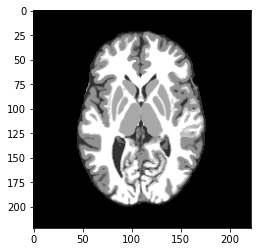

In [7]:
show(ideal_image)

In [8]:
G = 0.005
fov = ny
dwell_time = 1
gamma = 2* np.pi * 42.58
t = np.linspace(-1, 1, nx) * 1E-3 * fov
phase_inc = gamma * G * dwell_time
field = np.zeros([ny, nx], dtype = complex)
for y in range(ny):
    field[y] =  phase_inc * y 

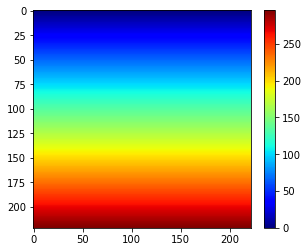

In [9]:
showc(field)

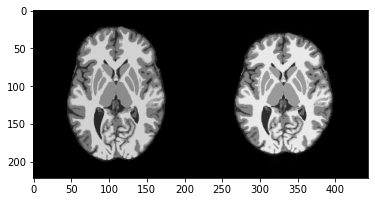

In [10]:
image = np.zeros([ny, nx], dtype = complex)
G = 0.01
fov = ny
dwell_time = 1
gamma = 2* np.pi * 42.58
t = np.linspace(-1, 1, nx) * 1E-3 * fov
phase_inc = gamma * G * dwell_time
for y in range(ny):
    modulation = np.exp(1j * t * field[y])
    modulation = np.repeat(modulation[:,None], nx, -1)
    tmp = ideal_image * modulation 
    image[y] = fft2c(tmp)[y]
contracted = ifft2c(image)
show(np.concatenate((ideal_image, contracted), -1) )

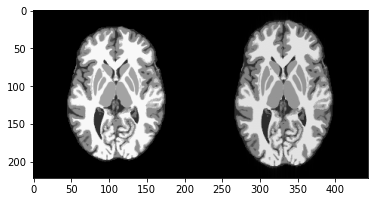

In [11]:
image = np.zeros([ny, nx], dtype = complex)
G = 0.01
fov = ny
dwell_time = 1
gamma = 2* np.pi * 42.58
t = np.linspace(-1, 1, nx) * 1E-3 * fov
phase_inc = gamma * G * dwell_time
for y in range(ny-1,0,-1):
    modulation = np.exp(1j * t * field[ny-y])
    modulation = np.repeat(modulation[:,None], nx, -1)
    tmp = ideal_image * modulation 
    image[y] = fft2c(tmp)[y]
extended = ifft2c(image)
show(np.concatenate((ideal_image, extended), -1) )

In [46]:
import SimpleITK as sitk
import sys
import os


def command_iteration(method, bspline_transform) :
    if method.GetOptimizerIteration() == 0:
        # The BSpline is resized before the first optimizer
        # iteration is completed per level. Print the transform object
        # to show the adapted BSpline transform.
        print(bspline_transform)


    print("{0:3} = {1:10.5f}".format(method.GetOptimizerIteration(),
                                     method.GetMetricValue()))



def command_multi_iteration(method) :
    # The sitkMultiResolutionIterationEvent occurs before the
    # resolution of the transform. This event is used here to print
    # the status of the optimizer from the previous registration level.
    if R.GetCurrentLevel() > 0:
        print("Optimizer stop condition: {0}".format(R.GetOptimizerStopConditionDescription()))
        print(" Iteration: {0}".format(R.GetOptimizerIteration()))
        print(" Metric value: {0}".format(R.GetMetricValue()))

    print("--------- Resolution Changing ---------")


def blip_reversed_correction_bspline_registration(target, moving):
    target = np.abs(target).astype(np.float64)
    moving = np.abs(moving).astype(np.float64)
    fixed = sitk.GetImageFromArray(target)
    moving = sitk.GetImageFromArray(moving)

    transformDomainMeshSize=[2]*fixed.GetDimension()
    tx = sitk.BSplineTransformInitializer(fixed,
                                          transformDomainMeshSize )


    R = sitk.ImageRegistrationMethod()
    R.SetMetricAsJointHistogramMutualInformation()

    R.SetOptimizerAsGradientDescentLineSearch(5.0,
                                              100,
                                              convergenceMinimumValue=1e-4,
                                              convergenceWindowSize=5)

    R.SetInterpolator(sitk.sitkLinear)

    R.SetInitialTransformAsBSpline(tx,
                                   inPlace=True,
                                   scaleFactors=[1,2,5])
    R.SetShrinkFactorsPerLevel([4,2,1])
    R.SetSmoothingSigmasPerLevel([4,2,1])

    # R.AddCommand( sitk.sitkIterationEvent, lambda: command_iteration(R, tx) )
    # R.AddCommand( sitk.sitkMultiResolutionIterationEvent, lambda: command_multi_iteration(R) )

    outTx = R.Execute(fixed, moving)

    # print("-------")
    # print(tx)
    # print(outTx)
    # print("Optimizer stop condition: {0}".format(R.GetOptimizerStopConditionDescription()))
    # print(" Iteration: {0}".format(R.GetOptimizerIteration()))
    # print(" Metric value: {0}".format(R.GetMetricValue()))

    # sitk.WriteTransform(outTx,  sys.argv[3])

    if ( not "SITK_NOSHOW" in os.environ ):

        resampler = sitk.ResampleImageFilter()
        resampler.SetReferenceImage(fixed);
        resampler.SetInterpolator(sitk.sitkLinear)
        resampler.SetDefaultPixelValue(0)
        resampler.SetTransform(outTx)

        out = resampler.Execute(moving)
        # # simg1 = sitk.Cast(sitk.RescaleIntensity(fixed), sitk.sitkUInt8)
        # out = sitk.Cast(sitk.RescaleIntensity(out), sitk.sitkUInt8)
        # cimg = sitk.Compose(simg1, simg2, simg1//2.+simg2//2.)
        # ref1 = sitk.GetArrayFromImage(simg2)
        # out = ref1.astype(np.float64)
        ref1 = sitk.GetArrayFromImage(out)
        out = ref1.astype(np.float64) 
    return out

In [47]:
recon1 = blip_reversed_correction_bspline_registration(ideal_image, extended)
recon2 = blip_reversed_correction_bspline_registration(ideal_image, contracted)

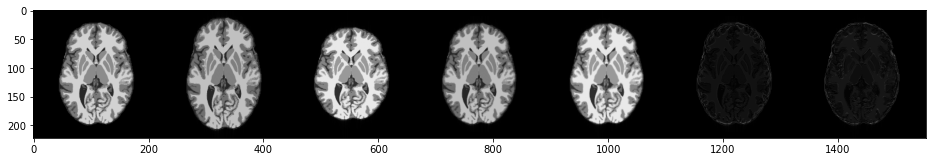

In [48]:
plt.figure(figsize = (16,12))
plt.imshow(np.abs(np.concatenate((ideal_image, extended, contracted, recon1, recon2, ideal_image-recon1, ideal_image-recon2), -1)), cmap = "gray" )
plt.show()